# Based on MS1 m/z matching, it is possible to find lipids and fatty acids 
## When plotted on an `m/z` vs. `RT` plot the user can spot patterns in the fatty acyls and use this as a quick check for outliers

## Automated outlier detection can be made more rigorous by fitting curves across fatty acyl carbon count and unsaturation count using a "grid" of best fit lines, fitted using Maximum Likelihood Estimation  

## You can search within one class for patterns 

In [168]:
import csv
import re 
from pathlib import Path
import json
from collections import defaultdict

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import molmass
from adjustText import adjust_text
# from lipidhandler import Lipid
# from liputils import Lipid
# from lipyd import lipid
# from rdkit.Chem import PandasTools
import pymsfilereader

from sklearn.preprocessing import PolynomialFeatures
from sklearn.linear_model import HuberRegressor, LinearRegression
import statsmodels.formula.api as smf

In [3]:
# data = pd.read_csv('../data/processed/lipidomics_linregress_normalized_data.csv')
# data.rename({'Quant Ion': 'm/z', 'Retention Time (min)': 'RT',
#              'Area (max)': 'Area (Max.)'}, inplace=True, axis=1)
# lipids = data.to_dict(orient='index')
# lipids[0]

In [4]:
# colors and class-superclass maps
with open(r'..\data\metadata\color_schemes.json') as infile:
    colors = json.load(infile, parse_int=True)
    
ap = pd.read_excel(r'..\data\metadata\animal_phenotypes.xlsx', index_col=0)

fg = pd.read_csv(r'..\data\metadata\combined_metab_lipid_file_grouping.csv', index_col=0)

# can't use the filtered dataset because most of the FAs have been removed
# Also don't use the Final Results output, use the Unfiltered Results 
final_results = pd.read_csv('../data/processed/lipidomics_linregress_normalized_data.csv')
data = pd.read_csv(r'../data/search/CD31/peak_finder/Unfiltered_Results.csv')
data.rename({'Quant Ion': 'm/z', 'Retention Time (min)': 'RT', 'Identification': 'ID', 
             'Area (max)': 'Area (Max.)'}, inplace=True, axis=1)
# display(data)
data.rename({fr_name: mod_name for fr_name, mod_name in zip(fg['fr_name'], fg.index)}, inplace=True, axis=1)
# display(data)
# data_cols = fg['fr_name']
data_cols = data.filter(regex='_RBG|_FBG').columns
data['mean'] = data[data_cols].mean(axis=1)
data['is_id'] = data['ID'].notna()
data.drop(data.filter(regex='Unnamed').columns, axis=1, inplace=True)
lipids = data.to_dict(orient='index')
lipids[0]
data

# LIPIDMAPS_DB = PandasTools.LoadSDF('../data/external/structures.sdf', 
#                                    embedProps=True, molColName=None, smilesName='smiles')

,RT,m/z,Polarity,Area (Max.),ID,Lipid Class,Features Found,Filter Status,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),...,1102_8_RBG,1102_9_FBG,1102_9_RBG,1102_10_FBG,1102_10_RBG,20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67),mean,is_id
0,0.528,664.07684,+,7.218670e+06,NaN,NaN,2,Dimer,3616.600742,3754.897464,...,2.456581e+06,4.949765e+06,3.271367e+06,3.898191e+06,3.586652e+06,4371.310119,3837.969412,3872.151793,3.760267e+06,False
1,0.529,662.08582,+,2.056865e+07,NaN,NaN,4,Dimer,4138.791646,4297.056647,...,1.187316e+07,1.415339e+07,5.295644e+06,9.765149e+06,1.210703e+07,5002.471406,4392.123121,4457.358249,1.230879e+07,False
2,0.530,991.11859,+,9.722884e+06,NaN,NaN,6,Adduct of existing peak,5222.040196,5421.727995,...,5.513680e+06,5.899307e+06,7.166797e+06,5.926878e+06,6.104699e+06,6484.218919,5541.676278,5623.985437,5.589505e+06,False
3,0.531,661.08264,+,7.778703e+07,NaN,NaN,44,Dimer,4970.354146,5160.417616,...,3.948893e+07,4.646823e+07,6.052133e+07,4.309350e+07,4.116755e+07,6171.699792,5274.584766,5352.926881,4.483563e+07,False
4,0.532,659.06866,-,6.691758e+07,NaN,NaN,47,Dimer,28520.354100,6130.634650,...,4.258937e+07,3.593391e+07,5.412068e+07,4.535156e+07,4.205162e+07,9011.421356,6850.520434,6319.495392,3.603261e+07,False
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3133,20.434,967.86713,+,3.380837e+06,NaN,NaN,4,Adduct of existing identified peak,12843.405760,13979.736960,...,7.847792e+05,2.203746e+05,1.180822e+06,3.224706e+05,5.614904e+05,23499.690490,14932.771020,18051.601980,4.950699e+05,False
3134,20.435,1003.93829,+,3.203813e+06,NaN,NaN,4,NaN,12695.823470,13819.097200,...,7.912981e+05,1.910285e+05,1.147269e+06,4.434897e+05,5.509051e+05,23229.657890,14761.180040,17844.172830,4.707392e+05,False
3135,20.452,1164.01404,+,3.204960e+06,NaN,NaN,2,NaN,13749.188890,14296.409340,...,7.236153e+05,3.054687e+04,1.097559e+06,2.851977e+04,5.293939e+05,24032.011160,15271.031760,18460.511230,2.975804e+05,False
3136,20.473,936.89600,+,2.627972e+06,TG 56:0,TG,6,RT out of class range,12059.809380,12539.792190,...,7.020718e+05,4.570013e+05,1.062921e+06,7.064462e+05,6.040003e+05,101141.455400,13090.673690,19330.809740,6.179504e+05,True


## Searching the metabolite data in CD 3.3 found lots of oxy-fatty acids
# Don't forget to look for Carnitines!
### There might also be some highly unsaturated fatty acids in the data, so look for those too 
### Calculate monoisotopic molecular weight for all ions in the series and check the unidentified features list for these

## Expand search to include all lipid classes 


In [5]:
water = 18.01056468403
O = 15.99491461957
H = 1.00782503223
C = 12.0
N = 14.00307400443
P = 30.97376199842
S = 31.9720711744

atoms = {
    'H': 1.00782503223,
    'C': 12.0,
    'N': 14.00307400443,
    'O': 15.99491461957,
    'P': 30.97376199842,
    'S': 31.9720711744,
}

# FA       =
AC       = 161.10519334659             # '(CH3)3 N CH2 CHOH CH2 CO2'
glycerol = 92.04734411655001           # 'CH2OH CHOH CH2OH'
PC       = 257.10282436487             # '(CH3)3N CH2 CH2 PO4 CH2 CHOH CH2OH'
PI       = 334.06649842606004          # 'C6O5H11 HPO4 CH2 CHOH CH2OH'
PE       = 215.05587417149002          # 'NH2 CH2 CH2 HPO4 CH2 CHOH CH2OH'
PG       = 246.05045443843             # 'CH2OH CHOH CH2 HPO4 CH2 CHOH CH2OH'
PS       = 259.04570341063             # 'HOCO CHNH2 CH2 HPO4 CH2 CHOH CH2OH'

Sph = 91.06332853364  # 'HOCH2 CHNH2 CH2OH'
SM  = 257.12663381419 # '(CH3)3 N CH2 CH2 HPO4 CH2 CHNH2 CH2OH'
Cer = 91.06332853364  # 'HOCH2 CHNH2 CH2OH'


# num_fa_cc means number of fatty acyls joined by a carbon-carbon linkage (like in SM, Cer)
# this is distinct from a connection made by a dehydration reaction 

lipid_class_data = {
    'FA': {'headgroup_mass': 31.989829239, 'num_fa_dehydro': 0, 'num_fa_cc': 0},
    
    'AC': {'headgroup_mass': 161.10519334, 'num_fa_dehydro': 1, 'num_fa_cc': 0}, # '(CH3)3 N CH2 CHOH CH2 CO2'
#     'Sph':{'headgroup_mass': Sph       , 'num_fa_dehydro': 0, 'num_fa_cc': 1},  # Sphingosines might be broken
    
    'TG': {'headgroup_mass': glycerol, 'num_fa_dehydro': 3, 'num_fa_cc': 0},
    'DG': {'headgroup_mass': glycerol, 'num_fa_dehydro': 2, 'num_fa_cc': 0},
    'MG': {'headgroup_mass': glycerol, 'num_fa_dehydro': 1, 'num_fa_cc': 0},
    
    'PC': {'headgroup_mass': PC, 'num_fa_dehydro': 2, 'num_fa_cc': 0},
    'PE': {'headgroup_mass': PE, 'num_fa_dehydro': 2, 'num_fa_cc': 0},
    'PG': {'headgroup_mass': PG, 'num_fa_dehydro': 2, 'num_fa_cc': 0},
    'PI': {'headgroup_mass': PI, 'num_fa_dehydro': 2, 'num_fa_cc': 0},
    'PS': {'headgroup_mass': PS, 'num_fa_dehydro': 2, 'num_fa_cc': 0},
    
    'LysoPC': {'headgroup_mass': PC, 'num_fa_dehydro': 1, 'num_fa_cc': 0},
    'LysoPE': {'headgroup_mass': PE, 'num_fa_dehydro': 1, 'num_fa_cc': 0},
    'LysoPG': {'headgroup_mass': PG, 'num_fa_dehydro': 1, 'num_fa_cc': 0},
    'LysoPI': {'headgroup_mass': PI, 'num_fa_dehydro': 1, 'num_fa_cc': 0},
    'LysoPS': {'headgroup_mass': PS, 'num_fa_dehydro': 1, 'num_fa_cc': 0},
    
    'SM': {'headgroup_mass': SM, 'num_fa_dehydro': 1, 'num_fa_cc': 1}, 
#     'Cer':{'headgroup_mass': Cer,'num_fa_dehydro': 1, 'num_fa_cc': 1},  # Ceramides currently off by 1 Hydrogen
}

In [6]:
def ppm_mass_error(found, actual):
    return (found - actual)/actual * 1e6

def is_within_ppm_tol(m1, m2, ppm_tol=7.5):
    return abs(m1 - m2) / m1 * 1e6 < ppm_tol

class ChemistryException(Exception):
    pass

def make_fatty_acid(C, unsat, O, carnitine=False):
    # O parameter = number of extra oxygens
    # num H's = 2 * C - (2 * unsats)
    # Max. num. of unsats = C/2 - 1
    if unsat > C / 2 - 1:
        raise ChemistryException('Too many unsaturations.')
    if O+1 > C:
        raise ChemistryException('Too many oxidations.')
    if O == 0:
        O_text = ''
    elif O == 1:
        O_text = 'O'
    else:
        O_text = f'O{O}'
    formula = 'O2' + (C * 'C') + (2 * C - (2 * unsat)) * 'H' + O_text
#     print(formula)
    f = molmass.Formula(formula)
    return f.isotope.mass, f.formula

make_fatty_acid(8, 0, 1)

def get_lipid_mass(headgroup_mass, num_fa_C, num_fa_unsat, num_fa_ox, num_fa_dehydrations, num_fa_cc_bond):
    """
    Calculates lipid's neutral monoisotopic mass from:
        1) neutral headgroup mass
        2) Number of fatty acyl carbons, oxidations and unsaturations 
        3) Number of fatty acyls that bond to headgroup via dehydration (loss of water)
        4) Number of fatty acyls that bond to headgroup via carbon-carbon bond (in case of SM, etc.)
    """
    return headgroup_mass \
           + (num_fa_C * atoms['C']) \
           + (atoms['H'] * (2*num_fa_C - (2*num_fa_unsat))) \
           + (atoms['O'] * num_fa_ox) \
           + (num_fa_dehydrations*atoms['O']) \
           - (2*num_fa_dehydrations*atoms['H']) \
           - (num_fa_cc_bond * ((3*atoms['C']) + (7*atoms['H'])))

dg_class_data = lipid_class_data['DG']
headgroup_mass = dg_class_data['headgroup_mass']
num_fa_dehydrations = dg_class_data['num_fa_dehydro']
num_fa_cc_bond = dg_class_data['num_fa_cc']
print(get_lipid_mass(headgroup_mass, 34, 1, 0, num_fa_dehydrations, num_fa_cc_bond))  # 594.52232535395

print(get_lipid_mass(lipid_class_data['AC']['headgroup_mass'], 16, 1, 0, 1, 0))  # 397.3192088686

print(get_lipid_mass(lipid_class_data['PC']['headgroup_mass'], 20, 1, 2, 2, 0))  # PC 20:1;O2 595.34853393897

print(get_lipid_mass(lipid_class_data['TG']['headgroup_mass'], 61, 1, 0, 3, 0)) # TG 61:1  986.92414164948

594.52232535395
397.31920886201004
595.34853393897
986.92414164948


In [7]:
def make_plot(df, plot_lines=True, figsize=(12, 9)):
    fig, ax = plt.subplots(figsize=figsize)
    sns.scatterplot(
        data=df, x='RT', y='mz_found', ax=ax, s=300,  # size='mean', sizes=(25, 120), 
        marker='s', alpha=0.3, hue='ppm_mass_error', palette='coolwarm',) # color='lightblue',
    # Plot connecting lines between each family
    if plot_lines: 
        unsat_range = range(df['unsat'].min(), df['unsat'].max() + 1)
        O_range = range(df['O'].min(), df['O'].max() + 1)
        unsat_color_palette = sns.color_palette('coolwarm', unsat_range.stop - unsat_range.start)
        for i, unsat in enumerate(unsat_range):
            for O in O_range:
                same_unsat_family = df.loc[(df['unsat'] == unsat) & (df['O'] == O)]
                if len(same_unsat_family) < 2:
                    continue
                same_unsat_family = same_unsat_family.sort_values('C')
                plt.plot(same_unsat_family['RT'], same_unsat_family['mz_found'],
                         c=unsat_color_palette[i], alpha=0.8, linewidth=1.2, zorder=-10)
    # carbon_color_palette = sns.color_palette('Purples', df['C'].max() - df['C'].min())
    # for i, C in enumerate(range(df['C'].min(), df['C'].max() + 1)):
    #     same_carbon_family = df.loc[(df['C'] == C)]
    #     same_carbon_family = same_carbon_family.sort_values('unsat')
    #     if len(same_carbon_family) < 2:
    #         continue
    #     plt.plot(same_carbon_family['RT'], same_carbon_family['m/z'], 
    #              c=carbon_color_palette[i], alpha=0.9, linewidth=1.2)
    texts = []
    fas_used = set()
    for i, row in df.iterrows():
        fa_text = row['fa_name']
    #     if fa_text in fas_used:
    #         continue
        fas_used.add(fa_text)
        texts.append(plt.annotate(
            text=fa_text, xy=(row['RT'], row['mz_found']), ha='center', va='center', size=9, color='black', 
            alpha=1, bbox=dict(facecolor='gray', edgecolor='white', alpha=0.1)))

    plt.title(f'MS1 search {", ".join([str(x) for x in df["class"].unique()])}', fontsize=18)
    plt.tick_params(labelsize=18)
    plt.ylabel('m/z', fontsize=22)
    plt.xlabel('Rentention time (min)', fontsize=18)
    plt.legend(markerscale=2, fontsize=14, title='Mass error (ppm)', title_fontsize=15)
    sns.despine()
    return fig, ax
    # plt.savefig(f'../reports/figures/1-0-2/FA_RT_mz_Ox{O_range.start}.png', 
    #             bbox_inches='tight', dpi=250, facecolor='white')

In [8]:
def big_search_function(lipid_classes,
                        adducts,
                        C_range,
                        unsat_range,
                        O_range,
                        results_file: str = None,
                        ppm_tol: float = 10,
                        only_ids: bool = False,
                        include_model: bool = False,
                        plot_mz_rt: bool = True):
    """
    Searches for MS1 matches to all possible FAs within a list of lipid classes
    Plots results of search on m/z vs. RT plot
    
    :param: results_file: LipiDex Final_Results.csv or Unfiltered_Results.csv file
    :param: lipid_classes: str or list of str of lipid class abbreviations (e.g. TG, PC, LysoPE)
    :param: adducts: str or list of str of adducts to search for in data (of form [M+H]+1)
    :param: C_range: tuple of (min_carbons, max_carbons) to search for in fatty acyls
    :param: unsat_range: tuple of (min_unsaturations, max_unsaturations) to search for in fatty acyls
    :param: O_range: tuple of (min_oxidations, max_oxidations) to search for in fatty acyls
    RANGES CAN ALSO BE A 3-TUPLE OF (START, STOP, STEP) to skip odd-chain fatty acyls, for example
    :param: only_ids: True if search will only look among identified lipids, for verifying mz/RT plot makes sense
                      False if searching only in un-identified lipid features, for finding missed lipids or FAs
                      
    :param: plot_mz_rt: True to plot a matplotlib m/z vs. RT plot to show matches
    :return: matplotlib axes with m/z vs. RT plot and pandas DataFrame of matches 
    """
    
    # Validate adducts for correct form
    if isinstance(adducts, str):
        adducts = [adducts,]
    for adduct in adducts:
        if adduct[0] != '[' or adduct[-3] != ']' or \
            (adduct[-2] != '-' and adduct[-2] != '+') or \
            (adduct[2] != '-' and adduct[2] != '+'):
            raise ValueError(f'Adduct {adduct} mis-specified, must be of form, e.g. "[M+NH4]+1"')
    adduct_regex = re.compile("(?<=[+-])(.*?)(?=\])")  # Uses lookbehinds to find the adduct's atoms between +- and ]
    adduct_dict = {}
    for adduct in adducts:
        adduct_formula = adduct_regex.search(adduct)[1]
        if adduct[-2] == '+':
            charge = 1
        elif adduct[-2] == '-':
            charge = -1
        if adduct[2] == '+':
            mass_multiplier = 1
        elif adduct[2] == '-':
            mass_multiplier = -1
        adduct_dict[adduct] = mass_multiplier * molmass.Formula(adduct_formula).isotope.mass
    
    if isinstance(lipid_classes, str):
        lipid_classes = [lipid_classes, ]  # turn lipid_class into a list if user provides a single string
    
    # Validate that lipid class is in the current database
    for cls in lipid_classes:
        if cls not in lipid_class_data:
            raise ValueError(f'{cls} lipid class not yet supported')
    
    # Populate dictionary of all theoretical lipids from the user-specified lipid classes and C, unsat, O ranges
    theoretical_lipids = {}
    for lipid_class in lipid_classes:
        headgroup_mass = lipid_class_data[lipid_class]['headgroup_mass']
        for C in range(*C_range):
            for unsat in range(*unsat_range):
                for O in range(*O_range):
                    if O == 0:
                        O_text = ''
                    elif O == 1:
                        O_text = ';O'
                    else:
                        O_text = f';O{O}'
                    fa_name = f'{C}:{unsat}{O_text}'
                    try:  
                        fa_mass, formula = make_fatty_acid(C, unsat, O)
                    except ChemistryException:  # fatty acid is impossible chemical structure
                        continue
                        
                    lipid_name = lipid_class + ' ' + fa_name
                    neutral_mass = get_lipid_mass(lipid_class_data[lipid_class]['headgroup_mass'],
                                                  C, unsat, O,
                                                  lipid_class_data[lipid_class]['num_fa_dehydro'],
                                                  lipid_class_data[lipid_class]['num_fa_cc'])
                    theoretical_lipids[lipid_name] = {'class': lipid_class, 'neutral_mass': neutral_mass, 
                                                      'adducts': {}, 'fa_name': fa_name, 
                                                      'C': C, 'unsat': unsat, 'O': O}
                    for adduct_name, adduct_mass in adduct_dict.items():
                        theoretical_lipids[lipid_name]['adducts'][adduct_name] = neutral_mass + adduct_mass
    
    # Read data, parse columns, add 'is_id' bool column
    if isinstance(results_file, str):
        df = pd.read_csv(results_file)
    else:
        df = results_file
#     df.rename({'Quant Ion': 'm/z', 'Retention Time (min)': 'RT', 'Area (max)': 'Area (Max.)'}, inplace=True, axis=1)
#     data_cols = fg['fr_name']
#     df['mean'] = df[data_cols].mean(axis=1)
#     df['is_id'] = df['Identification'].notna()
#     lipids = df.to_dict(orient='index')
    
    # Perform search of theoretical lipids in results file
    result = []
    min_mz, max_mz = df['m/z'].min(), df['m/z'].max()
    for i, row in df.iterrows():
        if only_ids and not row['is_id']:
            # Handle case where you want only IDs, but row is not ID, or the contrapositive case 
            continue
        for lipid_name, lipid_data in theoretical_lipids.items():
#             print(lipid_data)
            match = {}
            for adduct_name, adduct_mz in lipid_data['adducts'].items():
                if not min_mz-0.1 < adduct_mz < max_mz+0.1:  # Quick check to save a bit of time
                    continue
                if is_within_ppm_tol(adduct_mz, row['m/z'], ppm_tol=ppm_tol):
                    match['result_file_index'] = i
                    match['MS1_match_id'] = lipid_name
                    match['mz_found'] = row['m/z']
                    match['RT'] = row['RT']
                    match['adduct'] = adduct_name
                    match['class'] = lipid_data['class']
                    match['C'] = lipid_data['C']
                    match['unsat'] = lipid_data['unsat']
                    match['O'] = lipid_data['O']
                    match['fa_name'] = lipid_data['fa_name']
                    match[f'ppm_mass_error'] = ppm_mass_error(actual=adduct_mz, found=row['m/z'])
            if match:
                result.append(match)
    
    if plot_mz_rt:
        # make the plot
        pass
    
    return pd.DataFrame(result)
#     df = pd.DataFrame(result)
#     df['mean'] = df[data_cols].mean(axis=1)
#     df = df.drop_duplicates('MS1_match_id')

In [9]:
tgs = big_search_function(
    lipid_classes='TG', adducts='[M+NH4]+1',
#     adducts=['[M-H]-1', '[M+NH4]+1'],
#     adducts='[M+H]+1',
#     adducts='[M-H]-1',
    C_range=(30, 80), unsat_range=(0, 20), O_range=(0, 1), ppm_tol=3,
    only_ids = True,
#     results_file=r'../data/search/CD31/peak_finder/Unfiltered_Results.csv',
    results_file=data.loc[data['Filter Status'].isna()],)

(750.0, 1060.0)

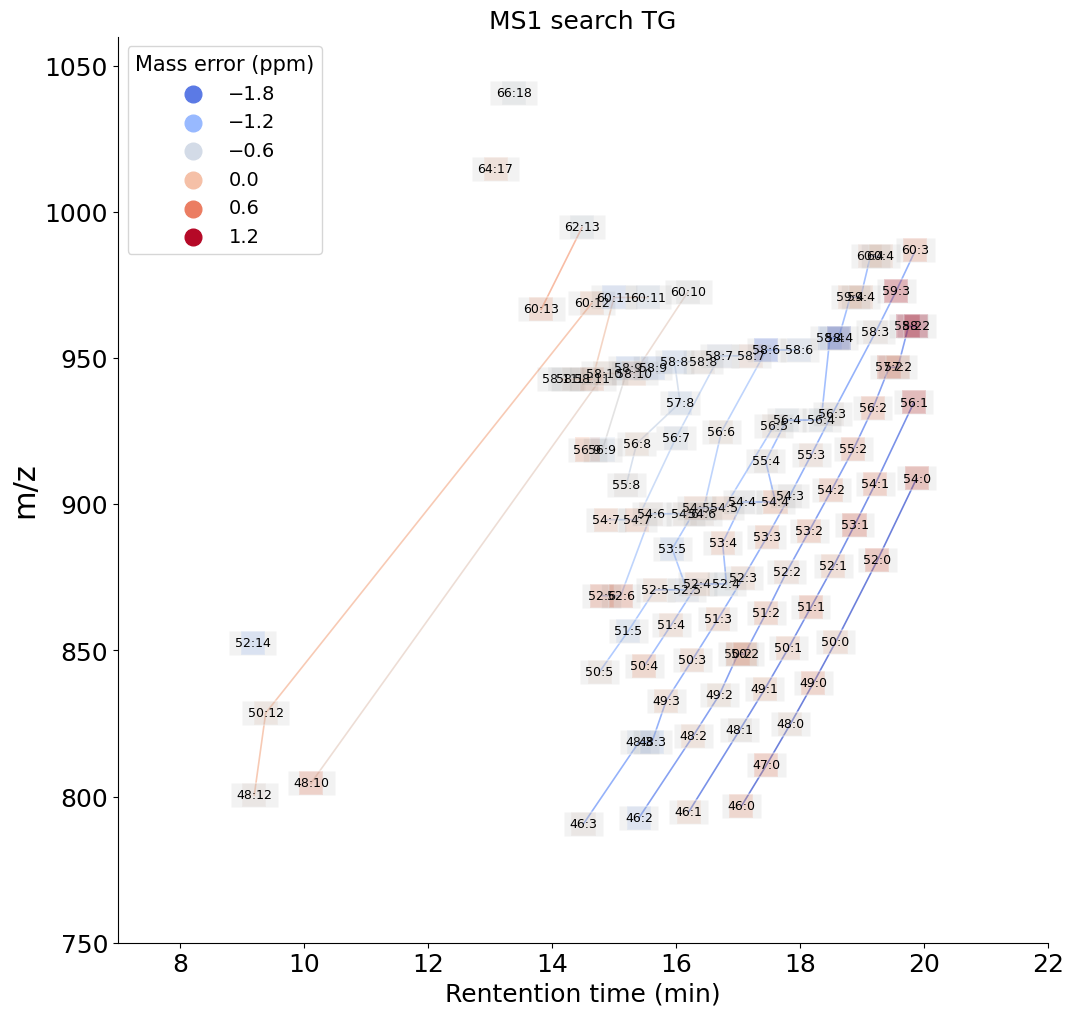

In [10]:
fig, ax = make_plot(tgs, figsize=(12, 12))
fig.set_dpi(100)
plt.xlim(7, 22)
plt.ylim(750, 1060)

(750.0, 1060.0)

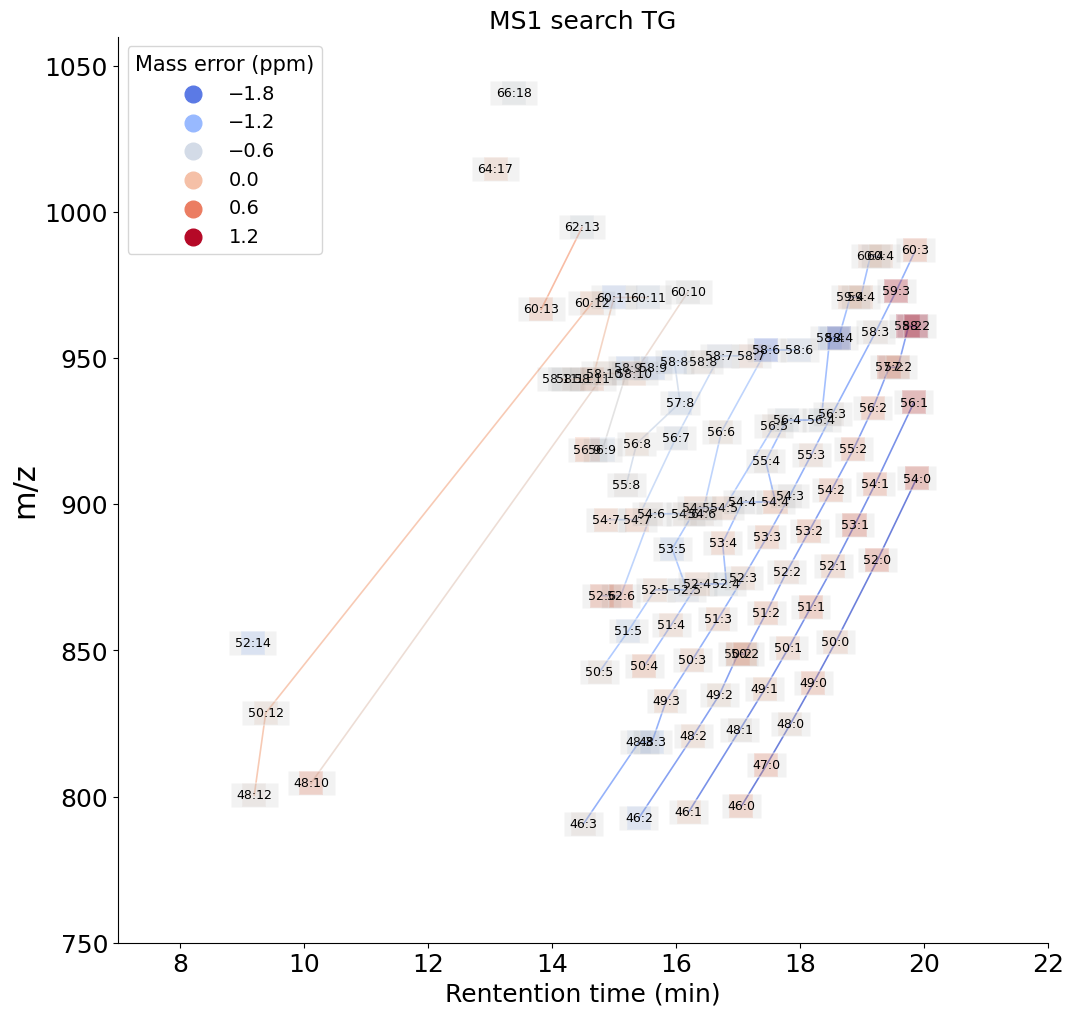

In [11]:
fig, ax = make_plot(tgs, figsize=(12, 12))
fig.set_dpi(100)
plt.xlim(7, 22)
plt.ylim(750, 1060)

In [12]:
fas = big_search_function(
    lipid_classes='FA', adducts='[M-H]-1',
    C_range=(0, 40), unsat_range=(0, 10), O_range=(0, 1), ppm_tol=5,
#     results_file=r'../data/search/CD31/peak_finder/Unfiltered_Results.csv',
    results_file=data,)

In [13]:
fas

,result_file_index,MS1_match_id,mz_found,RT,adduct,class,C,unsat,O,fa_name,ppm_mass_error
0,426,FA 18:4,275.20200,1.996,[M-H]-1,FA,18,4,0,18:4,3.251770
1,439,FA 20:5,301.21777,2.251,[M-H]-1,FA,20,5,0,20:5,3.369090
2,445,FA 20:5,301.21768,2.447,[M-H]-1,FA,20,5,0,20:5,3.070302
3,482,FA 18:3,277.21738,2.651,[M-H]-1,FA,18,3,0,18:3,2.253927
4,486,FA 22:6,327.23318,2.686,[M-H]-1,FA,22,6,0,22:6,2.367620
5,494,FA 14:0,227.20168,2.845,[M-H]-1,FA,14,0,0,14:0,2.530317
6,503,FA 22:6,327.23328,2.952,[M-H]-1,FA,22,6,0,22:6,2.673213
7,506,FA 21:5,315.23346,3.071,[M-H]-1,FA,21,5,0,21:5,3.345982
8,510,FA 20:4,303.23334,3.207,[M-H]-1,FA,20,4,0,20:4,3.082658
9,511,FA 16:1,253.21753,3.220,[M-H]-1,FA,16,1,0,16:1,3.059933


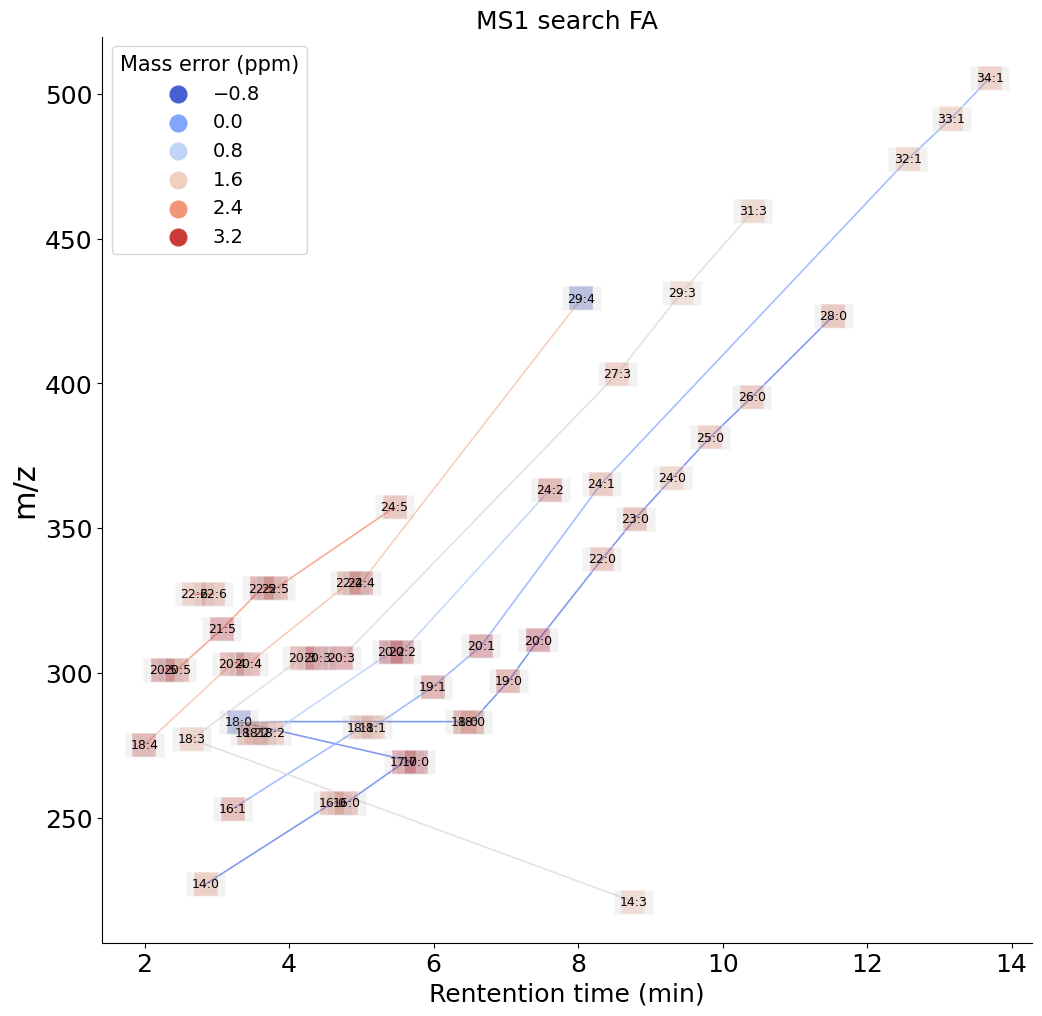

In [14]:
fig, ax = make_plot(fas, figsize=(12, 12))
fig.set_dpi(100)

## Many of the FAs look promising. Make robust linear model (or mixed effect model) and then calculate outliers

## Use pymsfilereader to find any MS2 spectra for these lipids
#### Many MS2s will be missing due to exclusion list 

In [21]:
fas['unsat_cat'] = fas['unsat'].astype('category')
fas

,result_file_index,MS1_match_id,mz_found,RT,adduct,class,C,unsat,O,fa_name,ppm_mass_error,unsat_cat
0,426,FA 18:4,275.20200,1.996,[M-H]-1,FA,18,4,0,18:4,3.251770,4
1,439,FA 20:5,301.21777,2.251,[M-H]-1,FA,20,5,0,20:5,3.369090,5
2,445,FA 20:5,301.21768,2.447,[M-H]-1,FA,20,5,0,20:5,3.070302,5
3,482,FA 18:3,277.21738,2.651,[M-H]-1,FA,18,3,0,18:3,2.253927,3
4,486,FA 22:6,327.23318,2.686,[M-H]-1,FA,22,6,0,22:6,2.367620,6
5,494,FA 14:0,227.20168,2.845,[M-H]-1,FA,14,0,0,14:0,2.530317,0
6,503,FA 22:6,327.23328,2.952,[M-H]-1,FA,22,6,0,22:6,2.673213,6
7,506,FA 21:5,315.23346,3.071,[M-H]-1,FA,21,5,0,21:5,3.345982,5
8,510,FA 20:4,303.23334,3.207,[M-H]-1,FA,20,4,0,20:4,3.082658,4
9,511,FA 16:1,253.21753,3.220,[M-H]-1,FA,16,1,0,16:1,3.059933,1


In [63]:
famlm.params

Intercept           -5.569631
C                    0.509369
unsat_cat Var        6.816453
unsat_cat x C Cov   -0.190293
C Var                0.009170
dtype: float64

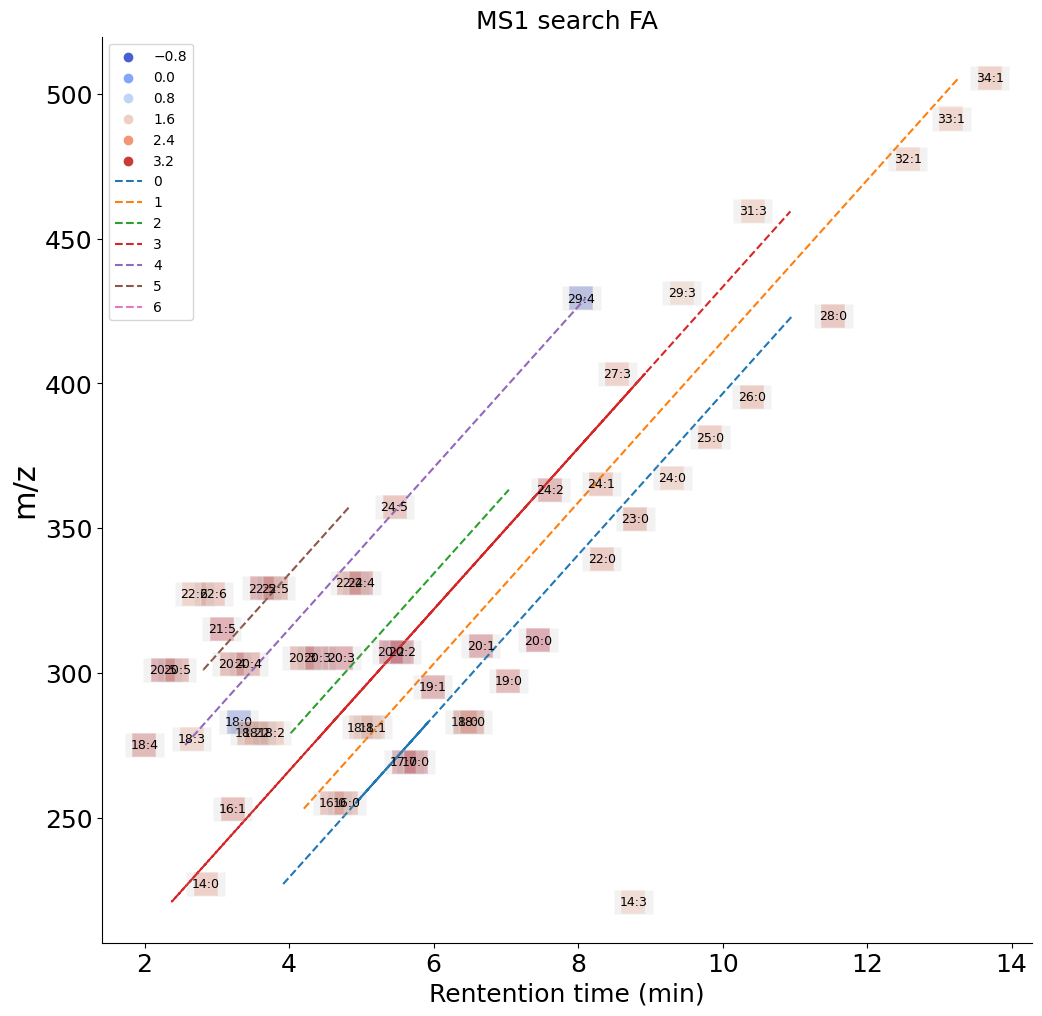

In [65]:
famlm = smf.mixedlm('RT ~ C', groups='unsat_cat', 
#                     vc_formula={'unsat_cat': '1'}, 
#                     re_formula='C', 
                    data=fas).fit(reml=True)
famlm.summary()

fig, ax = make_plot(fas, figsize=(12, 12), plot_lines=False)
fig.set_dpi(100)
main_intercept = famlm.fe_params['Intercept']
main_slope = famlm.fe_params['C']
for unsat in sorted(fas['unsat_cat'].unique()):
    df = fas.loc[fas['unsat_cat'] == unsat]
    intercept = main_intercept + famlm.random_effects[unsat]['unsat_cat']
#     slope = main_slope + famlm.random_effects[unsat]['C']
    slope = main_slope
    mzs = [mz for mz in df['mz_found']]
    rt_pred = [intercept + slope*C for C in df['C']]
    plt.plot(rt_pred, mzs, '--', label=unsat)
plt.legend()

## Go through files and find matches to FAs based on ms1 precursor and RT

[WindowsPath('../data/raw/lipidomics/20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw'),
 WindowsPath('../data/raw/lipidomics/20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw'),
 WindowsPath('../data/raw/lipidomics/20210729_AJ_Toh_RatBloodGlucose_T1060M_20210329_9wk_FBG.raw'),
 WindowsPath('../data/raw/lipidomics/20210729_AJ_Toh_RatBloodGlucose_T1060M_20210401_9wk_RBG.raw'),
 WindowsPath('../data/raw/lipidomics/20210729_AJ_Toh_RatBloodGlucose_T1060M_20210405_10wk_FBG.raw'),
 WindowsPath('../data/raw/lipidomics/20210729_AJ_Toh_RatBloodGlucose_T1060M_20210408_10wk_RBG.raw'),
 WindowsPath('../data/raw/lipidomics/20210729_AJ_Toh_RatBloodGlucose_T1062M_20210322_8wk_FBG.raw'),
 WindowsPath('../data/raw/lipidomics/20210729_AJ_Toh_RatBloodGlucose_T1062M_20210325_8wk_RBG.raw'),
 WindowsPath('../data/raw/lipidomics/20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC2.raw'),
 WindowsPath('../data/raw/lipidomics/20210729_AJ_Toh_RatBloodGlucose_T1062M_20210401_9wk_RBG.r

In [208]:
matches = {lipid: defaultdict(list) for lipid in fas['MS1_match_id']}
fas_to_search = {lipid: (mz, rt) for lipid, mz, rt in zip(fas['MS1_match_id'], fas['mz_found'], fas['RT'])}
max_rt = max(fas['RT']) + 1

rawfiles = [file for file in Path(r'..\data\raw\lipidomics').glob('*.raw') 
                if file.stem in fg.loc[fg['quant_file'], 'File Name_lipid'].values]

for file_counter, filepath in enumerate(rawfiles):
    print(filepath)
    file = pymsfilereader.MSFileReader(str(filepath))
    for i, scan_num in enumerate(range(file.FirstSpectrumNumber, file.LastSpectrumNumber)):
        if file.GetMSOrderForScanNum(scan_num) == 2:
            precursor_mz = file.GetPrecursorMassForScanNum(scan_num, 2)
            precursor_rt = file.RTFromScanNum(scan_num)
            if precursor_rt > max_rt:
                break
            for fa, (mz, rt) in fas_to_search.items():
                if np.isclose(mz, precursor_mz, rtol=5e-6, atol=0) and np.isclose(rt, precursor_rt, rtol=0, atol=1):
                    spectrum = file.GetMassListFromScanNum(scan_num, centroidResult=True)[0]
                    matches[fa][filepath.stem].append((scan_num, spectrum))
#         if i == 10:
#             break
#     if file_counter == 1:
#         break

..\data\raw\lipidomics\20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG.raw
..\data\raw\lipidomics\20210729_AJ_Toh_RatBloodGlucose_T1060M_20210325_8wk_RBG.raw
..\data\raw\lipidomics\20210729_AJ_Toh_RatBloodGlucose_T1060M_20210329_9wk_FBG.raw
..\data\raw\lipidomics\20210729_AJ_Toh_RatBloodGlucose_T1060M_20210401_9wk_RBG.raw
..\data\raw\lipidomics\20210729_AJ_Toh_RatBloodGlucose_T1060M_20210405_10wk_FBG.raw
..\data\raw\lipidomics\20210729_AJ_Toh_RatBloodGlucose_T1060M_20210408_10wk_RBG.raw
..\data\raw\lipidomics\20210729_AJ_Toh_RatBloodGlucose_T1062M_20210322_8wk_FBG.raw
..\data\raw\lipidomics\20210729_AJ_Toh_RatBloodGlucose_T1062M_20210325_8wk_RBG.raw
..\data\raw\lipidomics\20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC2.raw
..\data\raw\lipidomics\20210729_AJ_Toh_RatBloodGlucose_T1062M_20210401_9wk_RBG.raw
..\data\raw\lipidomics\20210729_AJ_Toh_RatBloodGlucose_T1062M_20210405_10wk_FBG.raw
..\data\raw\lipidomics\20210729_AJ_Toh_RatBloodGlucose_T1062M_20210408_10wk_RBG.

In [210]:
result = pd.DataFrame(matches).dropna(axis=1, how='all')
result

,FA 21:5,FA 24:5,FA 19:1,FA 24:2,FA 29:4,FA 27:3,FA 14:3,FA 29:3,FA 31:3,FA 28:0,FA 32:1,FA 33:1,FA 34:1
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210322_8wk_FBG,"[(699, ((52.27420804537697, 54.672071577032995...","[(1283, ((55.498993240773125, 59.5305265200144...","[(1345, ((59.59803818946649, 63.61094081499505...","[(1738, ((52.70375502230581, 59.08664801261339...",NaN,NaN,"[(1815, ((56.925743542431015, 64.0823938836417...",NaN,NaN,NaN,"[(3002, ((57.17366483061088, 58.70741752821865...",NaN,NaN
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210329_9wk_FBG,"[(690, ((55.457105741575646, 64.7875615764915,...","[(1282, ((51.471300352234245, 76.5015694189145...","[(1346, ((61.012597114381514, 81.6952744851086...","[(1742, ((53.193047741740706, 57.3836955192938...",NaN,NaN,"[(1789, ((62.04311501555747, 72.32254151145354...",NaN,NaN,NaN,"[(3037, ((60.006810701492604, 64.0366317102688...",NaN,"[(3344, ((52.1666358715989, 54.48317996284369,..."
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210401_9wk_RBG,"[(778, ((55.8737314824393, 59.51779181112147, ...","[(1273, ((63.44407861849008, 67.4442765202669,...","[(1353, ((62.696083393633465, 68.6576337149300...",NaN,NaN,"[(1985, ((51.116841411241246, 54.7998201235087...","[(1798, ((53.808285893526225, 54.3334451032953...",NaN,NaN,NaN,NaN,NaN,NaN
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210405_10wk_FBG,"[(688, ((60.123873159794485, 63.82672137949299...","[(1261, ((55.55915935383075, 56.62193367712496...","[(1339, ((54.03501454103212, 63.78239652376977...","[(1743, ((52.44546856586755, 57.61200325598273...","[(1853, ((50.82448229429012, 54.01034679861578...",NaN,"[(1808, ((56.52321078655161, 60.94522879494833...",NaN,NaN,NaN,"[(3042, ((56.441448526191344, 62.3746436232621...",NaN,NaN
20210729_AJ_Toh_RatBloodGlucose_T1060M_20210408_10wk_RBG,"[(761, ((58.172648215169964, 66.33413392322866...","[(1253, ((59.285087552795424, 65.1692827387320...","[(1342, ((52.02899965526131, 57.98113417999048...",NaN,"[(1814, ((56.9543191567774, 61.186940573099925...","[(1955, ((53.95329424496911, 58.31818053669842...","[(1786, ((62.60131284679571, 66.4290402978711,...",NaN,NaN,NaN,NaN,NaN,NaN
20210729_AJ_Toh_RatBloodGlucose_T1062M_20210322_8wk_FBG,"[(692, ((57.85170513680729, 68.46525328155798,...","[(1308, ((62.84069563533135, 63.81872540162289...","[(1400, ((61.46747982540428, 62.89664640920964...","[(1779, ((53.833917002415824, 54.9968113737501...",NaN,NaN,"[(1861, ((52.64418750425102, 53.57882300004016...",NaN,NaN,NaN,"[(3034, ((52.258494227028656, 54.3332603526195...",NaN,NaN
20210729_AJ_Toh_RatBloodGlucose_T1062M_20210325_8wk_RBG,"[(702, ((56.58094226847517, 57.412918957345404...","[(1260, ((55.975898643550664, 64.5452341939397...","[(1362, ((52.29165384827623, 54.40504607562033...",NaN,"[(1867, ((57.070538975313575, 71.0866357710314...","[(2008, ((52.132469881105486, 58.7119517457494...","[(1821, ((50.80408206767433, 55.35363103631196...",NaN,"[(2542, ((52.86800880397977, 56.92140492766362...",NaN,NaN,NaN,NaN
20210729_AJ_Toh_RatBloodGlucose_T1062M_20210329_9wk_FBG_QC2,"[(680, ((50.79686108133303, 54.21279081235562,...","[(1258, ((53.445075501470356, 54.2829194645176...","[(1361, ((50.42901355498823, 54.9526212992929,...","[(1771, ((53.154151462668906, 58.3610336262235...",NaN,NaN,"[(1812, ((50.021302717890926, 60.4391647095368...",NaN,NaN,NaN,"[(3079, ((70.5471257217778, 95.74492782118695,...",NaN,NaN
20210729_AJ_Toh_RatBloodGlucose_T1062M_20210401_9wk_RBG,"[(705, ((50.34469778467062, 52.30117461914976,...","[(1239, ((50.1548645490582, 63.16263722583076,...","[(1342, ((53.44090100629602, 59.80842026848495...",NaN,NaN,"[(1984, ((56.446663657880386, 70.5898408319044...","[(1809, ((65.62014799392244, 71.75568183269546...",NaN,NaN,NaN,NaN,NaN,NaN
20210729_AJ_Toh_RatBloodGlucose_T1062M_20210405_10wk_FBG,"[(667, ((56.92363860167175, 59.85847701512535,...","[(1239, ((51.332950862420056, 79.8314266778179...","[(1335, ((58.77776976378122, 64.23624081358346...","[(1738, ((68.0640986545457, 70.19344572428675,...",NaN,NaN,"[(1

In [212]:
test_spec = result.iloc[0, 0][0][1]
test_spec[0]

(52.27420804537697,
 54.672071577032995,
 58.83276158785069,
 60.109290449568455,
 61.86298295792445,
 62.45831439956138,
 71.64823104451577,
 92.341195292503,
 96.23661435558328,
 100.81711708465701,
 105.33537125707737,
 152.9991343082953,
 154.0776883849523,
 174.41629113074708,
 177.46534446062867,
 184.61227945132782,
 214.77227856929437,
 315.1560536263953,
 324.5067738937551)

<StemContainer object of 3 artists>

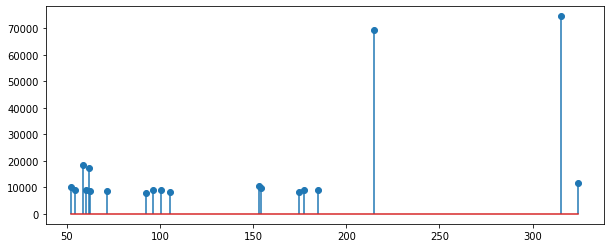

In [213]:
plt.gcf().set_size_inches(10, 4)
plt.stem(test_spec[0], test_spec[1])

# Acylcarnitines

In [74]:
ACs = big_search_function(
    lipid_classes='AC', adducts='[M+H]+1',
    C_range=(0, 40), unsat_range=(0, 6), O_range=(0, 1), ppm_tol=8,
#     results_file=r'../data/search/CD31/peak_finder/Unfiltered_Results.csv',
    results_file=data,)

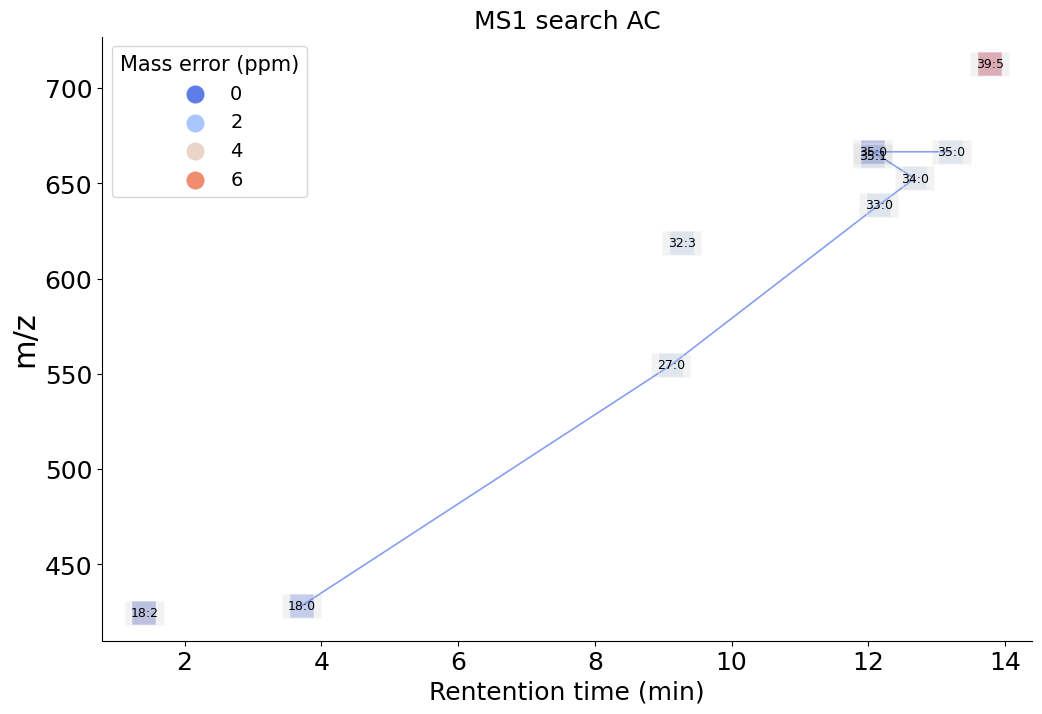

In [77]:
fig, ax = make_plot(ACs, figsize=(12, 8))
fig.set_dpi(100)

In [84]:
data.loc[(data['Lipid Class'] == 'PC') & (data['is_id'])]

,RT,m/z,Polarity,Area (Max.),ID,Lipid Class,Features Found,Filter Status,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),...,1102_8_RBG,1102_9_FBG,1102_9_RBG,1102_10_FBG,1102_10_RBG,20210729_AJ_Toh_RatBloodGlucose_Water_R1.raw (F65),20210729_AJ_Toh_RatBloodGlucose_Water_R2.raw (F66),20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67),mean,is_id
678,7.038,756.55524,+,1.720736e+06,PC 34:3,PC,9,NaN,19522.695250,43179.259540,...,8.239310e+05,3.879272e+05,1371565.547,6.326627e+05,8.482669e+05,27483.930890,17935.002280,17632.778200,8.260525e+05,True
733,7.620,784.58551,+,2.418476e+06,PC 36:3,PC,17,NaN,16484.968880,20826.335670,...,1.322811e+06,4.389126e+05,2045332.321,9.144297e+05,1.370257e+06,30180.369650,17969.234590,20761.063770,1.056453e+06,True
735,7.636,804.55408,+,9.967408e+06,PC 18:2_20:5,PC,58,NaN,9165.332296,8584.422646,...,9.967408e+06,3.190411e+06,9579808.492,2.854678e+06,9.303871e+06,12258.635550,10006.288500,11560.937260,4.134238e+06,True
739,7.637,862.56085,-,2.796771e+06,PC 18:2_20:5,PC,18,Redundant Identification,8753.403352,8761.310991,...,2.656149e+06,8.338700e+05,2726550.702,1.157232e+06,2.387283e+06,20282.095640,9773.177530,8484.575540,1.059539e+06,True
754,7.715,778.53589,+,1.201445e+07,PC 36:6,PC,31,NaN,8438.574962,7771.041406,...,8.670875e+06,3.141510e+06,7931783.795,5.952179e+06,8.191632e+06,9526.814264,8283.939214,7138.868814,4.916449e+06,True
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1788,11.567,868.68164,+,3.662546e+06,PC 42:3,PC,28,RT out of class range,11681.857930,14010.915460,...,3.092119e+06,1.936984e+05,2179444.423,2.431180e+05,2.498653e+06,18951.944510,13220.181410,16906.881930,1.059697e+06,True
1790,11.669,900.67108,-,2.342987e+06,PC 18:2_22:0,PC,24,Redundant Identification,10997.782750,12454.961800,...,2.342987e+06,4.885125e+05,1842940.232,7.422103e+05,1.329933e+06,15473.138770,12646.815820,12828.094270,8.944001e+05,True
1791,11.670,842.66449,+,5.688812e+06,PC 18:2_22:0,PC,70,RT out of class range,24180.388710,12734.344490,...,5.563344e+06,1.380985e+06,4641909.537,2.027315e+06,3.579391e+06,15802.351120,14593.483410,14882.317890,2.365179e+06,True
1843,12.182,856.68030,+,3.104418e+06,PC 41:2,PC,22,RT out of class range,75787.904670,22283.900330,...,2.072601e+06,6.126110e+05,1961244.383,8.963937e+05,1.462001e+06,28157.153110,17101.663800,22719.048920,9.934257e+05,True


(<Figure size 864x648 with 1 Axes>,
 <AxesSubplot:title={'center':'MS1 search PE, PC'}, xlabel='Rentention time (min)', ylabel='m/z'>)

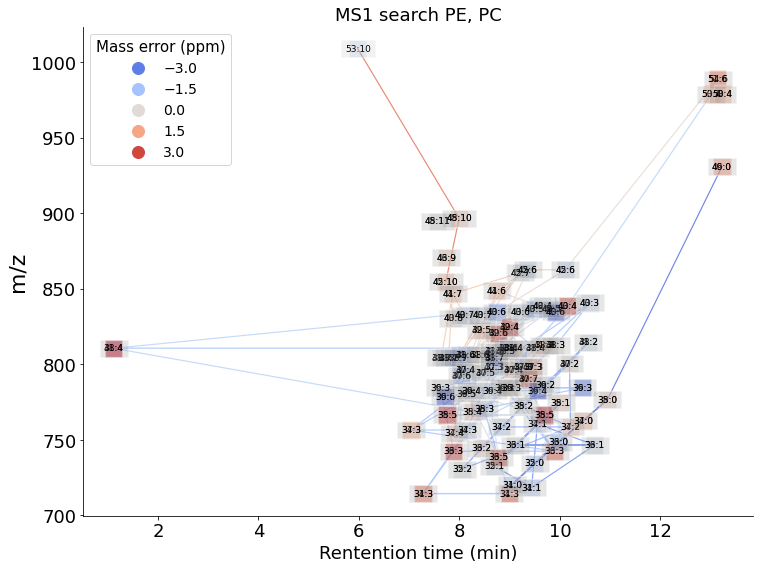

In [90]:
PCs = big_search_function(
    lipid_classes=['PE', 'PC'], adducts='[M+H]+1',
    C_range=(30, 55), unsat_range=(0, 18), O_range=(0, 1), ppm_tol=4,
#     results_file=r'../data/search/CD31/peak_finder/Unfiltered_Results.csv',
    only_ids=False,
    results_file=data.loc[data['Filter Status'].isna()],)


(<Figure size 864x648 with 1 Axes>,
 <AxesSubplot:title={'center':'MS1 search LysoPC'}, xlabel='Rentention time (min)', ylabel='m/z'>)

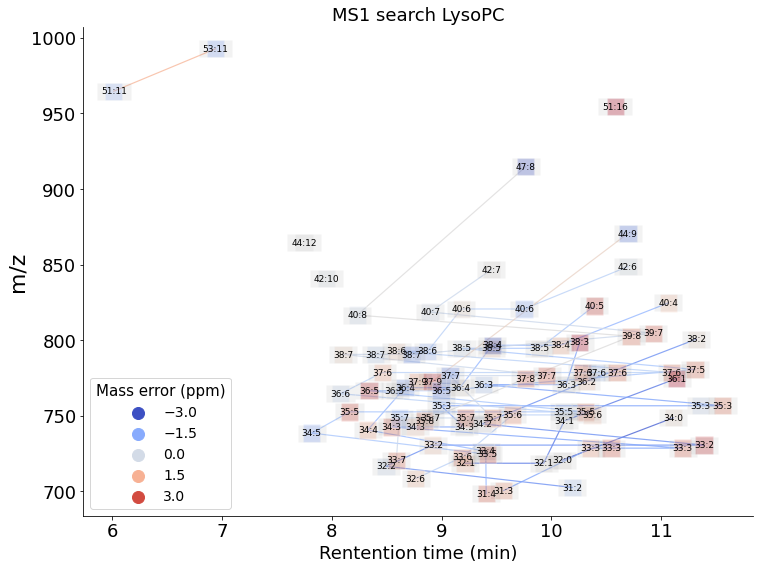

In [101]:
lysopc = big_search_function(
    lipid_classes=['LysoPC'], adducts='[M+H]+1',
    C_range=(30, 55), unsat_range=(0, 18), O_range=(0, 1), ppm_tol=4,
#     results_file=r'../data/search/CD31/peak_finder/Unfiltered_Results.csv',
    only_ids=False,
    results_file=data.loc[data['Filter Status'].isna()],)
make_plot(lysopc)

(<Figure size 864x648 with 1 Axes>,
 <AxesSubplot:title={'center':'MS1 search SM'}, xlabel='Rentention time (min)', ylabel='m/z'>)

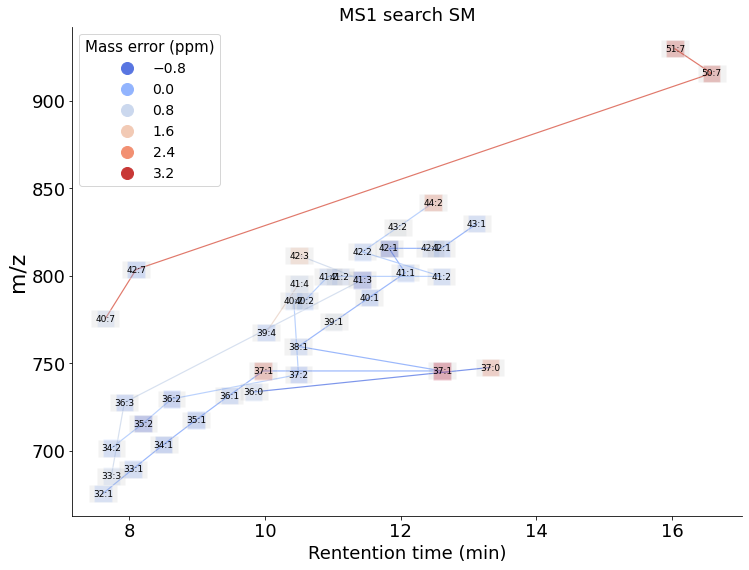

In [103]:
sm = big_search_function(
    lipid_classes=['SM'], adducts='[M+H]+1',
    C_range=(30, 55), unsat_range=(0, 18), O_range=(0, 1), ppm_tol=4,
#     results_file=r'../data/search/CD31/peak_finder/Unfiltered_Results.csv',
    only_ids=False,
    results_file=data.loc[data['Filter Status'].isna()],)
make_plot(sm)

In [96]:
data['Lipid Class'].value_counts()

TG              175
PC              112
Plasmanyl-PC     41
LysoPC           38
Plasmenyl-PE     29
SM               27
PI               16
Plasmanyl-PE     13
PE-NMe2          13
Plasmenyl-PC     12
Cer[NS]          11
PE                8
CE                4
AC                4
LysoPE            4
Alkenyl-DG        3
LysoPI            1
Name: Lipid Class, dtype: int64

In [690]:
# TG example
num_C = 61
num_unsat = 1
num_ox = 0
# The correction needs to be +1 Oxygen and -2 Hydrogen for every fatty acid joined by dehydration
num_fa = 3
glycerol + num_C*C + H*(2*num_C - (2*num_unsat)) + num_ox + (num_fa*O) - (2*num_fa*H)  

938.93939779077

In [553]:
# PC example
num_C = 40
num_unsat = 1
num_ox = 0
num_fa = 2
PC + num_C*C + H*(2*num_C - (2*num_unsat)) + num_ox + (num_fa*O) - (2*num_fa*H) 

843.6717059890301

In [557]:
# LysoPC example
num_C = 20
num_unsat = 1
num_ox = 0
num_fa = 1
PC + num_C*C + H*(2*num_C - (2*num_unsat)) + num_ox + (num_fa*O) - (2*num_fa*H) 

549.3794401447199

In [582]:
# SM example
num_C = 36
num_unsat = 1
num_ox = 0
num_fa_dehydro = 1
num_fa_cc = 1
SM + num_C*C + H*(2*num_C - (2*num_unsat)) + num_ox + \
    (num_fa_dehydro*O) - (2*num_fa_dehydro*H) - \
    num_fa_cc * ((3 * C) + (7 * H))


730.5988753997899

In [583]:
# Lyso SM example
num_C = 17
num_unsat = 1
num_ox = 0
num_fa_dehydro = 0
num_fa_cc = 1
SM + num_C*C + H*(2*num_C - (2*num_unsat)) + num_ox + \
    (num_fa_dehydro*O) - (2*num_fa_dehydro*H) - \
    num_fa_cc * ((3 * C) + (7 * H))

450.32225961994

In [584]:
### CERAMIDES ARE BROKEN BY 1 HYDROGEN
# Cer[NS] example
num_C = 38
num_unsat = 2
num_ox = 0
num_fa_dehydro = 1
num_fa_cc = 1
Cer + num_C*C + H*(2*num_C - (2*num_unsat)) + num_ox + \
    (num_fa_dehydro*O) - (2*num_fa_dehydro*H) - \
    num_fa_cc * ((3 * C) + (7 * H))

590.5512201837

In [586]:
# AC example
num_C = 16
num_unsat = 1
num_ox = 0
num_fa_dehydro = 1
num_fa_cc = 0
AC + num_C*C + H*(2*num_C - (2*num_unsat)) + num_ox + \
    (num_fa_dehydro*O) - (2*num_fa_dehydro*H) - \
    num_fa_cc * ((3 * C) + (7 * H))

397.3192088686

530.54266687567

In [689]:
# DG example

print(get_lipid_mass(lipid_class_data['DG']['headgroup_mass'], 34, 1, 0, 2, 0))

num_C = 34
num_unsat = 1
num_ox = 0
num_fa_dehydro = 2
num_fa_cc = 0
glycerol + num_C*C + H*(2*num_C - (2*num_unsat)) + num_ox + \
    (num_fa_dehydro*O) - (2*num_fa_dehydro*H) - \
    num_fa_cc * ((3 * C) + (7 * H))

562.53249611481


562.53249611481

<AxesSubplot:xlabel='RT', ylabel='mz_found'>

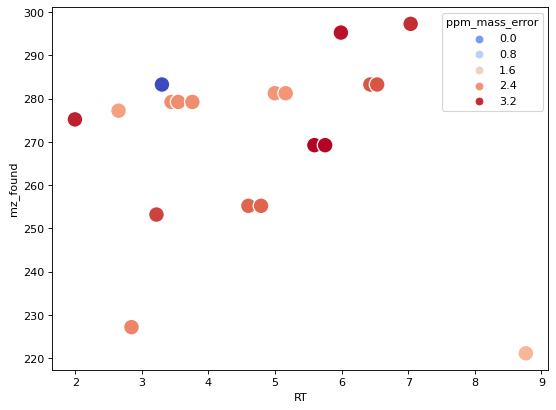

In [496]:
fig, ax = plt.subplots(figsize=(8, 6), dpi=80)
sns.scatterplot(
    data=r, x='RT', y='mz_found', hue='ppm_mass_error', palette='coolwarm',
    s=200, ax=ax
)

In [234]:
# def search_lipids(C_range=(0, 55), unsat_range=(0, 14), O_range=(0, 1)):
fas = {}
tol = 4
C_range = range(0, 55)
unsat_range = range(0, 13)
O_range = range(0,1)
y_array = [[[None for O in O_range] for unsat in unsat_range] for C in C_range]
fas_list = []
for C in C_range:
    for unsat in unsat_range:
        for O in O_range:
            if O == 0:
                O_text = ''
            elif O == 1:
                O_text = ';O'
            else:
                O_text = f';O{O}'
            fa_name = f'FA {C}:{unsat}{O_text}'
            try:  
                mimw, formula = make_fatty_acid(C, unsat, O)
            except ValueError:
                continue
            fas[fa_name] = {'mimw': mimw, 
                            '[M-H]-1': mimw-1.00782503223, 
                            '[M+NH4]+1': mimw+17.02654910112, 
                            'formula': formula,
                            'C': C, 'unsat': unsat, 'O': O}
            fas_list.append([C, unsat, O, mimw-1.00782503223])
result = []
training_data = []
for fa_name, fa in fas.items():
    for i, row in lipids.items():
        if row['is_id'] == False:
            if ppm_tol(fa['[M-H]-1'], row['m/z'], tol=tol):
                row['MS1_match_id'] = fa_name
                C, unsat, O = fa['C'], fa['unsat'], fa['O']
                row['C'] = C
                row['unsat'] = unsat
                row['O'] = O
                row['mass_error'] = ppm_mass_error(actual=fa['[M-H]-1'], found=row['m/z'])
                row['adduct'] = '[M-H]-1'
    #             y_array[C][unsat][O] = row['m/z']
                result.append(row)
                training_data.append([C, unsat, O, row['RT'], row['m/z']])  
            elif ppm_tol(fa['[M+NH4]+1'], row['m/z'], tol=tol):
                row['MS1_match_id'] = fa_name
                C, unsat, O = fa['C'], fa['unsat'], fa['O']
                row['C'] = C
                row['unsat'] = unsat
                row['O'] = O
                row['mass_error'] = ppm_mass_error(actual=fa['[M+NH4]+1'], found=row['m/z'])
                row['adduct'] = '[M+NH4]+1'
    #             y_array[C][unsat][O] = row['m/z']
                result.append(row)
                training_data.append([C, unsat, O, row['RT'], row['m/z']])
df = pd.DataFrame(result)
df['mean'] = df[data_cols].mean(axis=1)
df = df.drop_duplicates('MS1_match_id')

In [235]:
df

,RT,m/z,Polarity,Area (Max.),Identification,Lipid Class,Features Found,Filter Status,20210729_AJ_Toh_RatBloodGlucose_ExtractionBlank.raw (F1),20210729_AJ_Toh_RatBloodGlucose_SolventBlank.raw (F2),...,20210729_AJ_Toh_RatBloodGlucose_Water_R3.raw (F67),Unnamed: 75,mean,is_id,MS1_match_id,C,unsat,O,mass_error,adduct
0,2.845,227.20168,-,8.981391e+06,NaN,NaN,39,NaN,7.153289e+04,5.600870e+04,...,1.393392e+05,NaN,2.809514e+06,False,FA 14:0,14,0,0,2.530316,[M-H]-1
1,8.765,221.15460,-,2.464409e+07,NaN,NaN,3,NaN,1.249981e+06,1.188114e+06,...,1.156812e+06,NaN,7.574774e+06,False,FA 14:3,14,3,0,2.012551,[M-H]-1
2,4.600,255.23312,-,2.792112e+08,NaN,NaN,62,NaN,5.532255e+06,6.782391e+05,...,9.120908e+04,NaN,1.002415e+08,False,FA 16:0,16,0,0,2.800435,[M-H]-1
4,3.220,253.21753,-,2.810327e+07,NaN,NaN,2,NaN,1.875702e+05,9.878658e+04,...,4.380041e+05,NaN,9.943901e+06,False,FA 16:1,16,1,0,3.059933,[M-H]-1
5,5.591,269.24896,-,7.441422e+06,NaN,NaN,41,NaN,5.966776e+04,1.287959e+05,...,1.862659e+05,NaN,3.177221e+06,False,FA 17:0,17,0,0,3.360088,[M-H]-1
7,3.302,283.26349,+,1.632815e+06,NaN,NaN,2,NaN,1.578172e+04,1.521994e+04,...,1.579699e+04,NaN,1.014709e+05,False,FA 18:0,18,0,0,-0.760306,[M-H]-1
10,4.997,281.24872,-,5.361012e+08,NaN,NaN,43,NaN,1.846709e+06,7.155315e+05,...,5.502922e+04,NaN,1.550661e+08,False,FA 18:1,18,1,0,2.363384,[M-H]-1
12,3.446,279.23309,-,3.088387e+08,NaN,NaN,2,NaN,3.322454e+04,1.102945e+05,...,6.370302e+04,NaN,1.457461e+08,False,FA 18:2,18,2,0,2.452300,[M-H]-1
15,2.651,277.21738,-,2.540634e+07,NaN,NaN,5,NaN,1.320158e+04,1.198814e+04,...,2.064938e+04,NaN,1.017823e+07,False,FA 18:3,18,3,0,2.253926,[M-H]-1
16,1.996,275.20200,-,1.957360e+06,NaN,NaN,4,NaN,1.271670e+04,1.191704e+04,...,1.277098e+04,NaN,8.646372e+05,False,FA 18:4,18,4,0,3.251770,[M-H]-1


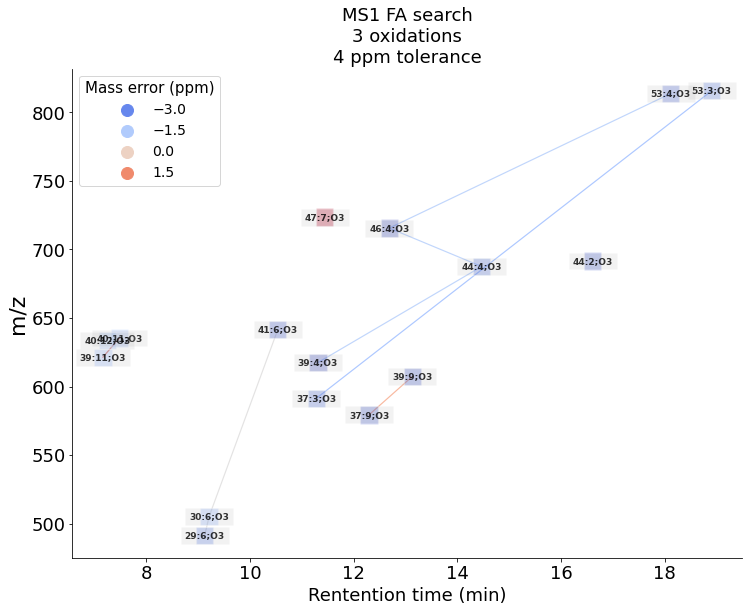

In [233]:
fig, ax = plt.subplots(figsize=(12, 9))
sns.scatterplot(
    data=df, x='RT', y='m/z', ax=ax,
    marker='s', alpha=0.3,
    hue='mass_error',  palette='coolwarm', # color='lightblue',
    s=300,
#     size='mean', sizes=(25, 120), 
)

# Plot connecting lines between each family
unsat_color_palette = sns.color_palette('coolwarm', unsat_range.stop)
for i, unsat in enumerate(unsat_range):
    for O in O_range:
        same_unsat_family = df.loc[(df['unsat'] == unsat) & (df['O'] == O)]
        if len(same_unsat_family) < 2:
            continue
        same_unsat_family = same_unsat_family.sort_values('C')
        plt.plot(same_unsat_family['RT'], same_unsat_family['m/z'],
                 c=unsat_color_palette[i], alpha=0.8, linewidth=1.2, zorder=-10)
# carbon_color_palette = sns.color_palette('Purples', df['C'].max() - df['C'].min())
# for i, C in enumerate(range(df['C'].min(), df['C'].max() + 1)):
#     same_carbon_family = df.loc[(df['C'] == C)]
#     same_carbon_family = same_carbon_family.sort_values('unsat')
#     if len(same_carbon_family) < 2:
#         continue
#     plt.plot(same_carbon_family['RT'], same_carbon_family['m/z'], 
#              c=carbon_color_palette[i], alpha=0.9, linewidth=1.2)

# texts = [plt.text(x[i], y[i], 'Text%s' %i, ha='center', va='center') for i in range(len(x))]
texts = []
fas_used = set()
for i, row in df.iterrows():
    fa_text = row['MS1_match_id'][3:]
#     if fa_text in fas_used:
#         continue
    fas_used.add(fa_text)
#     fa_text = fa_text.replace(':', '\n')#.replace(';', '\n')
    texts.append(plt.annotate(
#         s=fa_text, x=row['RT [min]'], y=row['m/z'],
        text=fa_text, xy=(row['RT'], row['m/z']), ha='center', va='center', size=9, color='black', 
        fontweight='semibold', alpha=0.8, bbox=dict(facecolor='gray', edgecolor='white', alpha=0.1)))
# adjust_text(texts, lim=1,
# #             only_move={'points':'y', 'texts':'y'}, 
# #             arrowprops=dict(arrowstyle="->", color='r', lw=0.5),
# plt.xlim(0, 17)
training_data = np.array(training_data)
plt.title(f'MS1 FA search\n{O_range.start} oxidations\n{tol} ppm tolerance', fontsize=18)
plt.tick_params(labelsize=18)
plt.ylabel('m/z', fontsize=22)
plt.xlabel('Rentention time (min)', fontsize=18)
plt.legend(markerscale=2, fontsize=14, title='Mass error (ppm)', title_fontsize=15)
sns.despine()
# plt.savefig(f'../reports/figures/1-0-2/FA_RT_mz_Ox{O_range.start}.png', 
#             bbox_inches='tight', dpi=250, facecolor='white')

In [19]:
training_data

array([[ 24.     ,   5.     ,   0.     ,   5.46   , 357.28036],
       [ 27.     ,   3.     ,   0.     ,   8.542  , 403.35858],
       [ 29.     ,   4.     ,   0.     ,   8.046  , 429.37283],
       [ 32.     ,   1.     ,   0.     ,  12.564  , 477.4682 ]])

## What does it look like to create a polynomial fit model for predicting FA Retention times based on num. carbons and num. unsaturations? 

### Array gets populated from the search loop above
### `[:, 0, 0]` slice gets all Chain lengths with 0 unsats and 0 Oxidations 

### Very robust regression would be nice to avoid the case of, e.g., the 14:3 FA that is totally out of line with the rest of the XX:3 FAs 

In [575]:
all_fas = pd.DataFrame(fas_list, columns=['C', 'unsat', 'O', 'mz'])
training_data = pd.DataFrame(training_data, columns=['C', 'unsat', 'O', 'rt', 'mz'])

In [20]:
PolynomialFeatures().fit_transform(np.array(training_data)[:, :-1])

array([[1.00000000e+00, 2.40000000e+01, 5.00000000e+00, 0.00000000e+00,
        5.46000000e+00, 5.76000000e+02, 1.20000000e+02, 0.00000000e+00,
        1.31040000e+02, 2.50000000e+01, 0.00000000e+00, 2.73000000e+01,
        0.00000000e+00, 0.00000000e+00, 2.98116000e+01],
       [1.00000000e+00, 2.70000000e+01, 3.00000000e+00, 0.00000000e+00,
        8.54200000e+00, 7.29000000e+02, 8.10000000e+01, 0.00000000e+00,
        2.30634000e+02, 9.00000000e+00, 0.00000000e+00, 2.56260000e+01,
        0.00000000e+00, 0.00000000e+00, 7.29657640e+01],
       [1.00000000e+00, 2.90000000e+01, 4.00000000e+00, 0.00000000e+00,
        8.04600000e+00, 8.41000000e+02, 1.16000000e+02, 0.00000000e+00,
        2.33334000e+02, 1.60000000e+01, 0.00000000e+00, 3.21840000e+01,
        0.00000000e+00, 0.00000000e+00, 6.47381160e+01],
       [1.00000000e+00, 3.20000000e+01, 1.00000000e+00, 0.00000000e+00,
        1.25640000e+01, 1.02400000e+03, 3.20000000e+01, 0.00000000e+00,
        4.02048000e+02, 1.00000000e+0

In [663]:
pred = all_fas.loc[(all_fas['C'] > 9) & (all_fas['C'] < 36) & (all_fas['unsat'] < 1)]
X_pred = pred[['C', 'unsat']]

true = training_data.loc[training_data['unsat'] == 0]
X_true = true[['C', 'unsat']]
X_poly = PolynomialFeatures(degree=2).fit_transform(X_true)
y_true = true['rt']

linear = LinearRegression().fit(X=X_true, y=y_true)
# (hr_linear.predict(training_data[['C', 'unsat']]) - training_data['rt']).round(1)
linear_predict = linear.predict(X_pred)


poly = LinearRegression().fit(X=X_poly, y=y_true)
poly_predict = poly.predict(PolynomialFeatures().fit_transform(X_pred))

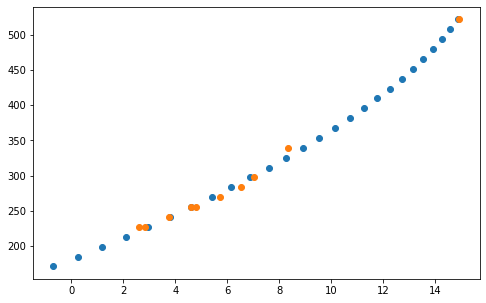

In [667]:
df = training_data.loc[training_data['unsat'] == 0]

# plt.scatter(linear_predict, pred['mz'])
plt.scatter(poly_predict, pred['mz'])
plt.scatter(df['rt'], df['mz'])
plt.gcf().set_size_inches(8, 5)

In [604]:
PolynomialFeatures(degree=2).fit_transform(training_data[:, :-1])

TypeError: '(slice(None, None, None), slice(None, -1, None))' is an invalid key

In [191]:
df['rt_norm'] = (df['RT [min]'] - df['RT [min]'].mean())/df['RT [min]'].std()
df['rt_norm']

0    -0.631249
1    -0.586962
2    -0.400257
3    -0.362730
4    -0.180687
5    -0.538712
6    -0.500719
7    -0.876692
8    -0.827277
9    -1.238214
10   -0.063443
11    0.031657
12   -0.152483
13   -0.441980
14   -0.407483
15   -0.681130
16   -0.602346
17   -0.628219
18   -0.587195
19   -0.955943
20   -1.178776
21   -0.987643
22    0.238175
23   -0.180920
24   -0.538479
25   -0.538479
26   -0.501185
27   -0.859210
28   -0.814923
29   -0.872496
30   -0.827277
31    0.345396
32    0.465204
33   -0.430792
34   -0.903497
35    0.586643
36    0.722068
37   -0.154814
38    0.287590
39    0.984760
40    0.495039
41    0.171977
42   -0.688822
43   -0.641039
44    0.460542
45   -0.489997
46   -0.837766
47    1.225075
48   -0.329165
49   -0.267163
50   -0.586962
51    2.534106
52    2.696336
53    0.837914
54    0.995016
55    2.168155
56    2.293790
57    2.500774
58    0.958421
59    2.294490
Name: rt_norm, dtype: float64